# Data Quality Problems

In [78]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [3]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from CollectData import DataManager

There appears to be some data quality issues that stem from missing and bad values within the inflation swap data and the breakeven data. For the ```sklearn``` package and the code to work its required that all of the data is present accross the curve. This sometimes isn't true, and can lead to gaps within the data. For the most part the gaps have been ignored. It appears that the model is quite sensitive to how those missing values get treated. 

## Identiftying missing values

Start by counting the data per each day

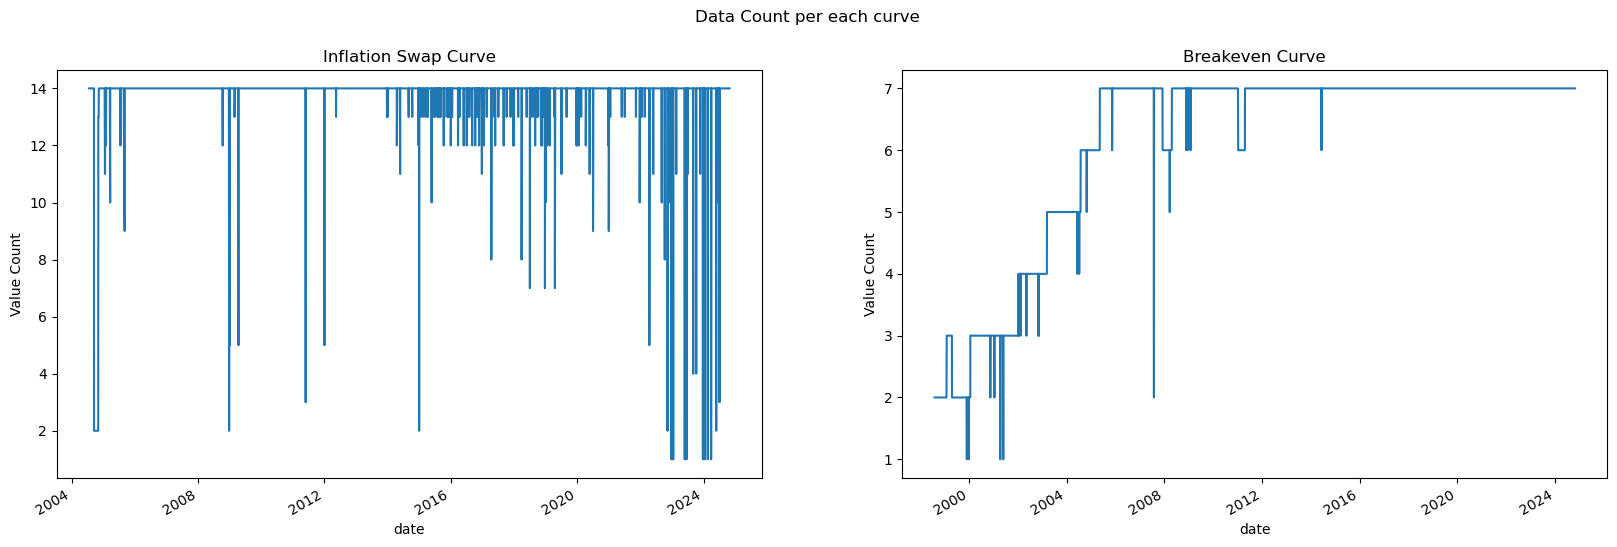

In [7]:
def plot_value_count() -> plt.Figure: 

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    
    (DataManager().get_inflation_swap().drop(
        columns = ["Description", "value"]).
        groupby("date").
        agg("count").
        plot(
            ax     = axes[0],
            title  = "Inflation Swap Curve",
            legend = False,
            ylabel = "Value Count"))
    
    (DataManager().get_breakeven().drop(
        columns = ["Description", "value"]).
        groupby("date").
        agg("count").
        plot(
            ax     = axes[1],
            title  = "Breakeven Curve",
            legend = False,
            ylabel = "Value Count"))

    fig.suptitle("Data Count per each curve")

plot_value_count()

It's evident that quotes per each curve don't begin at the same time. In this case use ```ffill``` to sort of "infer" the data point to see what number of tenors "go live". 

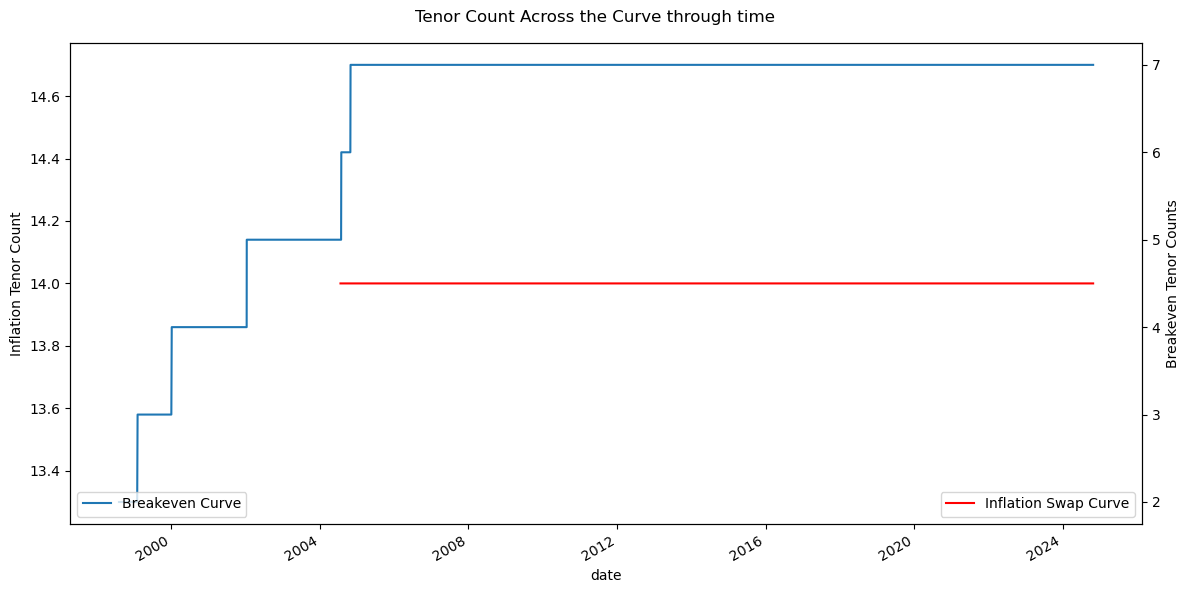

In [18]:
def plot_curve_count() -> plt.Figure: 

    fig, axes  = plt.subplots(figsize = (12,6))
    twinx_axes = axes.twinx()
    
    (DataManager().get_inflation_swap().drop(
        columns = "Description").
        pivot(index = "date", columns = "security", values = "value").
        ffill().
        reset_index().
        melt(id_vars = "date").
        drop(columns = ["value"]).
        rename(columns = {
            "security": "Inflation Swap Curve"}).
        groupby("date").
        agg("count").
        plot(
            ax     = axes,
            color  = "red",
            ylabel = "Inflation Tenor Count"))
    
    (DataManager().get_breakeven().drop(
        columns = ["Description"]).
        pivot(index = "date", columns = "security", values = "value").
        ffill().
        reset_index().
        melt(id_vars = "date").
        dropna().
        drop(columns = ["value"]).
        rename(columns = {
            "security": "Breakeven Curve"}).
        groupby("date").
        agg("count").
        plot(
            ax     = twinx_axes,
            ylabel = "Breakeven Tenor Counts"))
    
    axes.legend(loc = "lower right")
    twinx_axes.legend(loc = "lower left")
    fig.suptitle("Tenor Count Across the Curve through time")
    plt.tight_layout()

plot_curve_count() 

Looking at the tenor count per curve its fair to start at ~2004 which works well. Therefore the question at hand is clean these holes. 

In [82]:
def _get_missing_count(df: pd.DataFrame, start_date: dt.date) -> pd.DataFrame: 

    df_out = (df.query(
        "date >= @start_date").
        drop(columns = ["Description"]).
        pivot(index = "date", columns = "security", values = "value").
        reset_index().
        melt(id_vars = "date").
        query("value != value").
        drop(columns = ["security"]).
        fillna(1).
        groupby("date").
        agg("sum"))

    return df_out

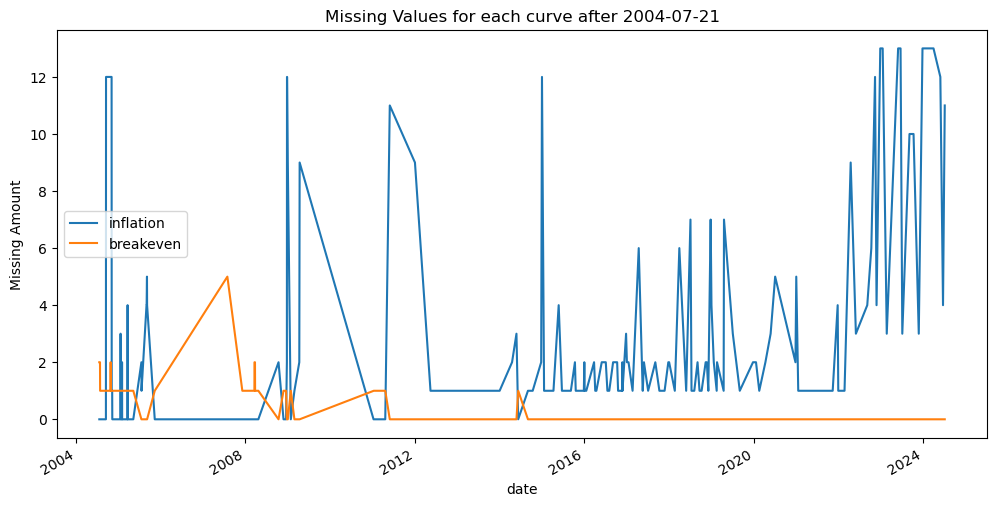

In [116]:
def plot_holes() -> pd.DataFrame:

    df_inflation, df_breakeven = DataManager().get_inflation_swap(), DataManager().get_breakeven()
    start_date = max([df_inflation.date.min(), df_breakeven.date.min()])
    
    (_get_missing_count(df_inflation, start_date).rename(
        columns = {"value": "inflation"}).
        merge(right = _get_missing_count(df_breakeven, start_date), how = "outer", on = ["date"]).
        fillna(0).
        rename(columns = {"value": "breakeven"}).
        plot(
            figsize = (12,6),
            ylabel  = "Missing Amount",
            title   = "Missing Values for each curve after {}".format(
                start_date.date())))

plot_holes()